In [1]:
!pip install fi
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fi: filename=fi-0.0.2-py3-none-any.whl size=1332 sha256=ecf85df7a230b57350c67b6fee95a30a53d00e11afd735ff5e19da80b25068e5
  Stored in directory: /root/.cache/pip/wheels/ab/37/f0/e3e3f6edfad1e5eab467667de40a095e9e29ca8d0be62433dd
Successfully built fi
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.9 MB/s eta 0:00:00


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=738a6afcfac3b42f1aa6c6885e1c46459b7e8a09d4308968c1ec90770f5315c9
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [3]:
!pip install pytorch-gradcam
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5267 sha256=446a71347dd075946b110202a75557e50289197e111e93e0d7c49b2e3424adcc
  Stored in directory: /root/.cache/pip/wheels/6f/f1/8f/96c81d13f617841f23cae192a77fea3e9e988d058ba9414f2c
Successfully built pytorch-gradcam
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=3823eaaefaf8526b685abdbc2cfb11113ccce8549a8120d4023b51f73bea220a
  Sto

In [4]:
!pip install unzip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1310 sha256=6ba89ea21c448a880aa86b7336571aa9f746a8d3ec8037e236704d618f16e72e
  Stored in directory: /root/.cache/pip/wheels/80/dc/7a/f8af45bc239e7933509183f038ea8d46f3610aab82b35369f4
Successfully built unzip


In [5]:
import timm
import fastai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import PIL


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
!unzip -qq '/content/drive/My Drive/Geolocation/50States10K.zip' -d '/content/geolocation'

In [9]:

config = SimpleNamespace(
    batch_size=32,
    img_size=224,
    seed=42,
    pretrained=True,
    normalize=True,
    model_name="vit_small_patch32_224",
    epochs=20,  # FIX THIS LATER
    learning_rate=2e-3,
    resize="crop",
)



In [10]:
def albumentations_transforms(x: PIL.Image.Image, img_size=224):
    transforms = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.ImageCompression(quality_lower=99, quality_upper=100),
            A.ShiftScaleRotate(
                shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7
            ),
            A.Resize(img_size, img_size),
            A.Cutout(
                max_h_size=int(img_size * 0.4),
                max_w_size=int(img_size * 0.4),
                num_holes=1,
                p=0.5,
            ),
        ]
    )

    return PIL.Image.fromarray(transforms(image=np.array(x))["image"])

def load_test_data(augment):
    resize_method = (
        ResizeMethod.Crop
    )

    if augment:
        dls = fastai.vision.data.ImageDataLoaders.from_folder(
            "/content/geolocation/",
            valid_pct=0.99,
            seed=config.seed,
            bs=config.batch_size,
            item_tfms=[
                Resize(config.img_size, method=resize_method),
                albumentations_transforms,
            ],
        )
    else:
        dls = fastai.vision.data.ImageDataLoaders.from_folder(
            "/content/geolocation/",
            valid_pct=0.99,
            seed=config.seed,
            bs=config.batch_size,
            item_tfms=[Resize(config.img_size, method=resize_method)],
        )

    mean, std = (0.48145466, 0.4578275, 0.40821073), (
        0.26862954,
        0.26130258,
        0.27577711,
    )

    if config.normalize:
        dls.add_tfms([Normalize.from_stats(mean, std)], "after_batch")

    return dls

In [11]:
import cv2
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad, \
    DeepFeatureFactorization

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    preprocess_image
from pytorch_grad_cam.ablation_layer import AblationLayerVit

In [12]:
def create_learner(model_name, dls=None, augment=False, test_set=False):
    if dls is None:
        dls = load_test_data(augment)

    learn = vision_learner(
        dls,
        model_name,
        concat_pool=True,
    ).to_fp16()

    # To device
    learn.dls.device = device

    return learn
  
learn = create_learner("resnet18", augment=False, test_set=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
def load_wandb_model(model_num, learn):
    run = wandb.init()
    artifact = run.use_artifact(f"ben_z/geolocation/model:v{model_num}", type="model")
    artifact_dir = artifact.download()
    file = torch.load(os.path.join(artifact_dir, "model.pth"), map_location=device)

    # create a learner with vit_small_patch32_224
    learn.model.load_state_dict(file)

    # Move model to GPU
    learn.model = learn.model.to(device)
    learn.dls.device = device

    return learn

In [14]:
wandb.finish()
learn = load_wandb_model(15, learn)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb:   1 of 1 files downloaded.  


In [15]:
model = learn.model[0].model
model.eval

<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1):

In [16]:
import matplotlib.pyplot as plt
from math import ceil, sqrt

def display_grid_image(class_image_list):
    # Calculate the grid size
    num_images = len(class_image_list)
    grid_size = ceil(sqrt(num_images))

    # Set up the matplotlib figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # Flatten axes array if only 1 row or column
    if grid_size == 1:
        axes = [axes]

    # Iterate through the class-image list and add them to the grid
    for idx, (cls, img) in enumerate(class_image_list):
        row, col = divmod(idx, grid_size)
        ax = axes[row][col]
        ax.imshow(img)
        ax.set_title(cls)
        ax.axis("off")

    # Remove unused subplots
    for idx in range(num_images, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row][col])

    # Show the grid
    plt.show()


In [116]:
device = torch.device('cpu')

In [239]:
def visualize(path, state=None, cam=EigenCAM):
  rgb_img = cv2.imread(path, 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
  input_tensor = input_tensor.to(device)
  target_layers = [learn.model[0].model.layer4[-1]]
  cam = cam(model=model, target_layers=target_layers, use_cuda=True)
  targets = None if not state else [ClassifierOutputTarget(list(learn.dls.vocab).index(state))]
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

  prediction = learn.predict(path)
  # print(prediction[0])
  # prediction = prediction.argmax(dim=-1)
  # Get the model's prediction
  # print(learn.dls.vocab[prediction])
  # print(prediction)
  return prediction[0], Image.fromarray(visualization)

In [240]:
# learn.model

In [241]:
def create_image(path):
  img = cv2.imread(path, 1)[:, :, ::-1]
  img = cv2.resize(img, (224, 224))

  rgb_img = np.float32(img) / 255
  input_tensor = preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], 
                                              std=[0.229, 0.224, 0.225])
  
  input_tensor = input_tensor
  return img, rgb_img, input_tensor

def create_labels(concept_scores, top_k=2):
    """ Create a list with the image-net category names of the top scoring categories"""
    labels = learn.dls.vocab
    # print(labels)
    concept_categories = np.argsort(concept_scores, axis=1)[:, ::-1][:, :top_k]
    concept_labels_topk = []
    for concept_index in range(concept_categories.shape[0]):
        categories = concept_categories[concept_index, :]    
        concept_labels = []
        # print(concept_categories)
        for category in categories:
            # print(categories)
            score = concept_scores[concept_index, category]
            label = f"{labels[category]}:{score:.2f}"
            concept_labels.append(label)
        concept_labels_topk.append("\n".join(concept_labels))
    return concept_labels_topk

from pytorch_grad_cam.utils.image import show_factorization_on_image

def visualize_image(path, n_components=5, top_k=2):
    model = learn.model
    model.eval()
    img, rgb_img_float, input_tensor = create_image(path)
    classifier = model[1]
    model = model.to(device)
    dff = DeepFeatureFactorization(model=model[0].model, target_layer=model[0].model.layer4[-1], 
                                   computation_on_concepts=model[1][-1])
    # print("dff created")
    input_tensor = input_tensor.to(device)
    concepts, batch_explanations, concept_outputs = dff(input_tensor, n_components)


    # print("dff used")
    concept_outputs = torch.softmax(torch.from_numpy(concept_outputs), axis=-1).numpy()    
    concept_label_strings = create_labels(concept_outputs, top_k=top_k)
    visualization = show_factorization_on_image(rgb_img_float, 
                                                batch_explanations[0],
                                                image_weight=0.3,
                                                concept_labels=concept_label_strings)
    
    result = np.hstack((img, visualization))
    
    # Just for the jupyter notebook, so the large images won't weight a lot:
    if result.shape[0] > 500:
        result = cv2.resize(result, (result.shape[1]//4, result.shape[0]//4))
    
    with torch.no_grad():
      model_output = model(input_tensor)
      softmax_output = torch.softmax(model_output, dim=-1)
      confidence, class_pred = torch.max(softmax_output, dim=-1)
      class_pred = class_pred.item()
      confidence = confidence.item()

    return Image.fromarray(result), class_pred, confidence

Alaska 0.9999581575393677


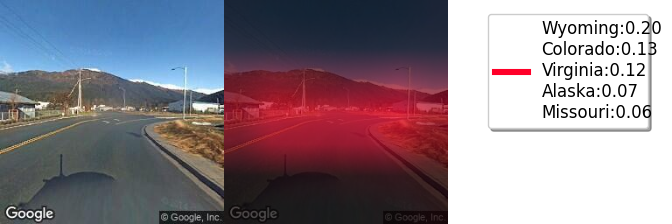

In [242]:
results = []
state = "Alaska"
for image in os.listdir(f"/content/geolocation/{state}")[:10]:
  results.append(visualize_image(f"/content/geolocation/{state}/{image}", 1, 5))

print(learn.dls.vocab[results[0][1]], results[0][2])
results[1][0]

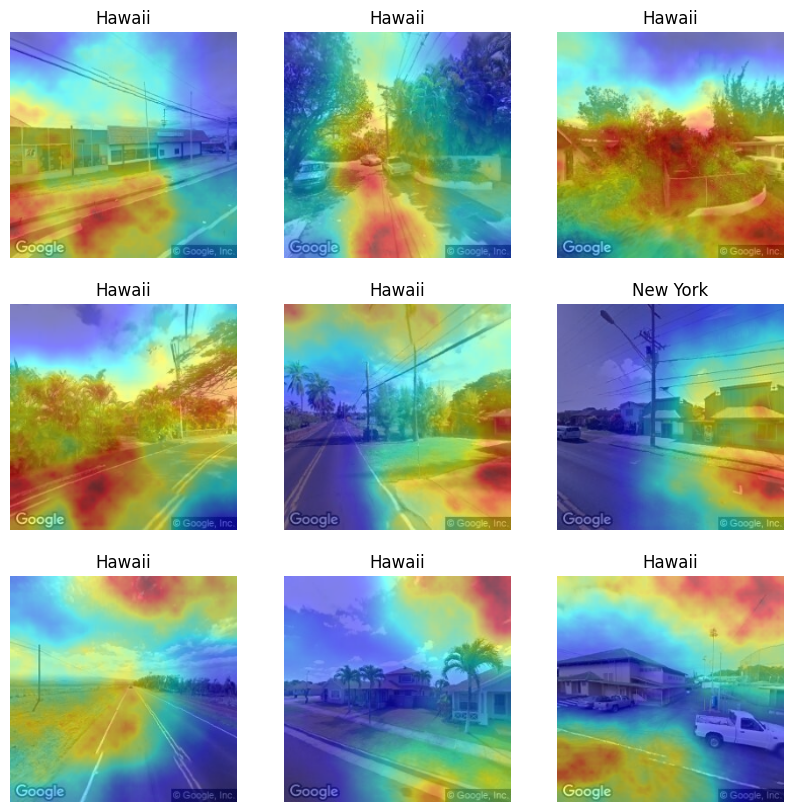

In [251]:
results = []
state = "Hawaii"
for image in os.listdir(f"/content/geolocation/{state}")[:9]:
  results.append(visualize(f"/content/geolocation/{state}/{image}", state, cam=FullGrad))
display_grid_image(results)

In [244]:
def enlarge(image):
    target_size = (512, 512)
    resized_image = image.resize(target_size)
    return resized_image

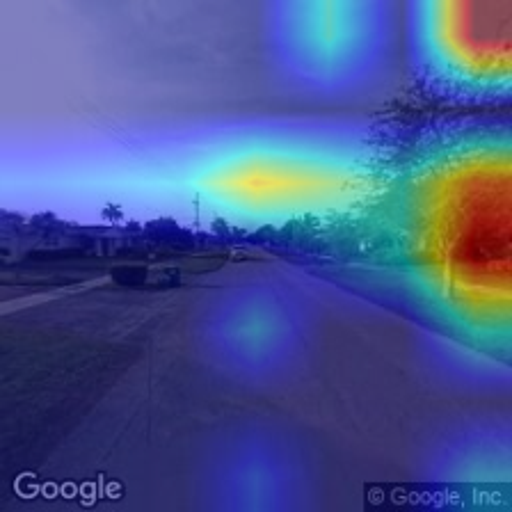

In [245]:
enlarge(results[1][1])